In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from dateutil.parser import isoparse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Set universal font sizes using rcParams
plt.rcParams['axes.labelsize'] = 18  # For x and y labels
plt.rcParams['xtick.labelsize'] = 18  # For x-ticks
plt.rcParams['ytick.labelsize'] = 18  # For y-ticks
plt.rcParams['legend.fontsize'] = 18  # For legend
plt.rcParams['axes.titlesize'] = 18

In [2]:
def construct_formatted_df(input_csv):
    formatted_df_original = pd.read_csv(input_csv, index_col=0)
    formatted_df = formatted_df_original.drop(columns=['Timestamp', 'Enclosure'], axis=1)
    return formatted_df_original, formatted_df

In [3]:
def generate_failure_counts(formatted_df):
    failure_counts = formatted_df.groupby(['Rack id', 'Unique enclosure']).size().reset_index(name='Failures')
    return failure_counts

In [4]:
def create_pivot_table(failure_counts):
    pivot_table = failure_counts.pivot('Unique enclosure', 'Rack id', 'Failures')
    return pivot_table

In [5]:
def generate_rack_enc_plot(alpine_pivot_table, camp_pivot_table):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 3))
    
    for i in alpine_pivot_table.index:
        for j in alpine_pivot_table.columns:
            failures = alpine_pivot_table.loc[i, j]
            if pd.notna(failures): 
                axs[0].scatter(j, i, s=failures*3, alpha=0.5, color='orangered') 

    axs[0].set_xlabel('Racks')
    axs[0].set_ylabel('Enclosures')
    axs[0].grid(True, linestyle=':', alpha=0.8)

    label_xticks = [1, 5, 10, 15, 20, 25, 30, 35, 39]
    all_xticks = np.arange(1, 40, 1)
    axs[0].set_xticks(ticks=all_xticks)
    axs[0].set_xticklabels([str(label) if label in label_xticks else '' for label in all_xticks])
    label_yticks = [2, 4, 6, 8]
    all_yticks = np.arange(1, 9, 1)
    axs[0].set_yticks(ticks=all_yticks)
    axs[0].set_yticklabels([str(label) if label in label_yticks else '' for label in all_yticks])
    axs[0].set_title('(a) Alpine')
    
    
    for i in camp_pivot_table.index:
        for j in camp_pivot_table.columns:
            failures = camp_pivot_table.loc[i, j]
            if pd.notna(failures): 
                axs[1].scatter(j, i, s=failures*2, alpha=0.8, color='limegreen') 

    axs[1].set_xlabel('Racks')
    axs[1].set_ylabel('Enclosures')
    axs[1].grid(True, linestyle=':', alpha=0.8)


    label_xticks = [2, 4, 6, 8, 10, 12, 14, 16]
    all_xticks = np.arange(1, 17, 1)
    axs[1].set_xticks(ticks=all_xticks)
    axs[1].set_xticklabels([str(label) if label in label_xticks else '' for label in all_xticks])
    label_yticks = [1, 2, 3, 4, 5, 6]
    all_yticks = np.arange(1, 7, 1)
    axs[1].set_yticks(ticks=all_yticks)
    axs[1].set_yticklabels([str(label) if label in label_yticks else '' for label in all_yticks])
    axs[1].set_title('(b) Campaign')


    
    
    plt.tight_layout()
    plt.savefig("rack_vs_enc.pdf", bbox_inches='tight')
    plt.show()


In [6]:
def print_important_info(failure_counts):
    heatmap_data = failure_counts.pivot("Unique enclosure", "Rack id", "Failures")
    
    for enclosure in heatmap_data.index:
        for rack in heatmap_data.columns:
            failure_count = heatmap_data.at[enclosure, rack]
            #if pd.notna(failure_count):  
                #print(f"Enclosure {enclosure}, Rack {rack}: {int(failure_count)} Failures")
            #else:
                #print(f"Enclosure {enclosure}, Rack {rack}: No Data")
            
    data_flat = heatmap_data.values.flatten()
    data_flat = data_flat[~pd.isnull(data_flat)]
    ranges = [(0, 25), (25, 50), (50, 75), (75, 100), (100, float('inf'))]
    range_counts = []

    for lower, upper in ranges:
        if upper == float('inf'): 
            count = (data_flat >= lower).sum()
        else:
            count = ((data_flat >= lower) & (data_flat < upper)).sum()
        range_counts.append(count)

    total_valid = len(data_flat)
    percentages = [(count / total_valid * 100) if total_valid else 0 for count in range_counts]

    range_labels = ["0-25", "25-50", "50-75", "75-100", "100+"]
    for label, percentage in zip(range_labels, percentages):
        print(f"{label}: {percentage:.2f}%")

    print("Counts per range:", dict(zip(range_labels, range_counts)))

    high_failure_combos = {}

    for enclosure in heatmap_data.index:
        for rack in heatmap_data.columns:
            failure_count = heatmap_data.at[enclosure, rack]
            if pd.notna(failure_count) and failure_count >= 25 and failure_count < 50:
                high_failure_combos[(enclosure, rack)] = int(failure_count)

    if high_failure_combos:
        print("Rack-Enclosure Combinations with 25<Failures>50: ")
        for (enclosure, rack), count in high_failure_combos.items():
            print(f"Enclosure {enclosure}, Rack {rack}: {count} Failures")
    else:
        print("No combinations have more than 100 Failures.")



In [7]:
def prepare_data_enc_driveslot_plot(formatted_df_original):
    if 'Timestamp' in formatted_df_original.columns:
        formatted_df_original['Timestamp'] = pd.to_datetime(formatted_df_original['Timestamp'], utc=True, errors='coerce')
        formatted_df_original['Year'] = formatted_df_original['Timestamp'].dt.year
    else:
        print("Timestamp column not found in DataFrame.")

    failure_counts_slots_by_year = formatted_df_original.groupby(['Year', 'slot bin hor', 'slot bin ver']).size().reset_index(name='Failures(slots)')
    return failure_counts_slots_by_year

In [8]:
def generate_enc_driveslot_plot_alpine(failure_counts_slots_by_year):
    unique_years = failure_counts_slots_by_year['Year'].unique()

    fig, axes = plt.subplots(1, len(unique_years), figsize=(10, 2), sharey=True)  # Adjust the figsize as necessary


    for ax, year in zip(axes, unique_years):
        year_data = failure_counts_slots_by_year[failure_counts_slots_by_year['Year'] == year]
        print(year)
        print("----")
        year_total = year_data["Failures(slots)"].sum()
        first_half_sum = year_data.query("`slot bin ver`==1")["Failures(slots)"].sum() + \
        year_data.query("`slot bin ver`==2")["Failures(slots)"].sum() + \
        year_data.query("`slot bin ver`==3")["Failures(slots)"].sum() + \
        year_data.query("`slot bin ver`==4")["Failures(slots)"].sum()
        top_panel = year_data.query("`slot bin hor`==1")["Failures(slots)"].sum() + \
        year_data.query("`slot bin hor`==2")["Failures(slots)"].sum()
        print("first half: ", (first_half_sum-top_panel)/year_total)

        second_half_sum = year_data.query("`slot bin ver`==5")["Failures(slots)"].sum() + \
        year_data.query("`slot bin ver`==6")["Failures(slots)"].sum() + \
        year_data.query("`slot bin ver`==7")["Failures(slots)"].sum() + \
        year_data.query("`slot bin ver`==8")["Failures(slots)"].sum()
        print("second half: ", second_half_sum/year_total)
        print("top panel: ", top_panel/year_total)

        #print(year_data.query("`slot bin ver`==1")["Failures(slots)"].sum())
        #print(year_data.query("`slot bin ver`==2")["Failures(slots)"].sum())
        #print(year_data.query("`slot bin ver`==3")["Failures(slots)"].sum())
        #print(year_data.query("`slot bin ver`==4")["Failures(slots)"].sum())
        #print(year_data.query("`slot bin ver`==5")["Failures(slots)"].sum())
        #print(year_data.query("`slot bin ver`==6")["Failures(slots)"].sum())
        #print(year_data.query("`slot bin ver`==7")["Failures(slots)"].sum())
        #print(year_data.query("`slot bin ver`==8")["Failures(slots)"].sum())



        pivot_table = year_data.pivot("slot bin hor", "slot bin ver", "Failures(slots)")

        if year != 2023:
            sns.heatmap(pivot_table, ax=ax,linewidths=.5, cmap='YlOrBr', cbar=False)
            for _, spine in ax.spines.items():
                spine.set_color('black')
                spine.set_linewidth(0.5)
                spine.set_visible(True)

            ax.margins(x=0.05, y=0.05)
        else:
            sns.heatmap(pivot_table, ax=ax,linewidths=.5, cmap='YlOrBr')
            for _, spine in ax.spines.items():
                spine.set_color('black')
                spine.set_linewidth(0.5)
                spine.set_visible(True)

            ax.margins(x=0.05, y=0.05)

        ax.set_title(year)
        ax.set_xlabel('')
        if ax is axes[0]:
            ax.set_ylabel('Enclosure \nfront')
        else:
            ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    fig.text(0.44, -0.02, 'Drive slots', va='center', fontsize=18)
    fig.text(0.45, 1.02, '(a) Alpine', va='center', fontsize=18)

    plt.tight_layout()

    plt.gcf().canvas.draw()


    ax = axes[4]
    color_bar = ax.collections[0].colorbar
    color_bar.set_label('# Failures')

    plt.savefig("drive_slots_years_ornl.pdf", bbox_inches='tight')
    plt.show()

In [9]:
def generate_enc_driveslot_plot_camp(failure_counts_slots_by_year):
    unique_years = failure_counts_slots_by_year['Year'].unique()

    fig, axes = plt.subplots(1, len(unique_years), figsize=(5, 1.8), sharey=True)  


    for ax, year in zip(axes, unique_years):
        year_data = failure_counts_slots_by_year[failure_counts_slots_by_year['Year'] == year]

        print(year)
        print("----")
        year_total = year_data["Failures(slots)"].sum()
        first_half_sum = year_data.query("`slot bin ver`==1")["Failures(slots)"].sum() + \
        year_data.query("`slot bin ver`==2")["Failures(slots)"].sum() + \
        year_data.query("`slot bin ver`==3")["Failures(slots)"].sum() 
        print("first half: ", first_half_sum/year_total)

        second_half_sum = year_data.query("`slot bin ver`==4")["Failures(slots)"].sum() + \
        year_data.query("`slot bin ver`==5")["Failures(slots)"].sum() + \
        year_data.query("`slot bin ver`==6")["Failures(slots)"].sum() 
        print("second half: ", second_half_sum/year_total)


        #print(year_data.query("`slot bin ver`==1")["Failures(slots)"].sum())
        #print(year_data.query("`slot bin ver`==2")["Failures(slots)"].sum())
        #print(year_data.query("`slot bin ver`==3")["Failures(slots)"].sum())
        #print(year_data.query("`slot bin ver`==4")["Failures(slots)"].sum())
        #print(year_data.query("`slot bin ver`==5")["Failures(slots)"].sum())
        #print(year_data.query("`slot bin ver`==6")["Failures(slots)"].sum())


        pivot_table = year_data.pivot("slot bin hor", "slot bin ver", "Failures(slots)")

        if year != 2023:
            sns.heatmap(pivot_table, ax=ax,linewidths=.5, cmap='YlGn', cbar=False)
            for _, spine in ax.spines.items():
                spine.set_color('black')
                spine.set_linewidth(0.25)
                spine.set_visible(True)

            ax.margins(x=0.05, y=0.05)
        else:
            sns.heatmap(pivot_table, ax=ax,linewidths=.5, cmap='YlGn')
            for _, spine in ax.spines.items():
                spine.set_color('black')
                spine.set_linewidth(0.25)
                spine.set_visible(True)


            ax.margins(x=0.05, y=0.05)



        ax.set_title(year)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    fig.text(0.37, -0.02, 'Drive slots', va='center', fontsize=15)
    fig.text(0.3, 1.02, '(b) Campaign', va='center', fontsize=15)

    plt.tight_layout()

    plt.gcf().canvas.draw()


    ax = axes[2]
    color_bar = ax.collections[0].colorbar
    color_bar.set_label('# Failures')

    plt.savefig("drive_slots_years_lanl.pdf", bbox_inches='tight')
    plt.show()

In [10]:
def main():
    #construct formatted df
    alpine_formatted_df_original, alpine_formatted_df= construct_formatted_df("../alpine_formatted_data.csv")
    camp_formatted_df_original, camp_formatted_df = construct_formatted_df("../camp_formatted_data.csv")
    
    #rack and enclosure counting
    alpine_failure_counts = generate_failure_counts(alpine_formatted_df)
    camp_failure_counts = generate_failure_counts(camp_formatted_df)
    
    #create pivot table
    alpine_pivot_table = create_pivot_table(alpine_failure_counts)
    camp_pivot_table = create_pivot_table(camp_failure_counts)
    
    #generate rack-enclosure bubble plot
    generate_rack_enc_plot(alpine_pivot_table, camp_pivot_table)
    
    #print relevant info
    print("*********** Alpine ***********")
    print_important_info(alpine_failure_counts)
    print("*********** Campaign ***********")
    print_important_info(camp_failure_counts)
    
    #prepare data for enc drive slot analysis
    alpine_failure_counts_enc = prepare_data_enc_driveslot_plot(alpine_formatted_df_original)
    camp_failure_counts_enc = prepare_data_enc_driveslot_plot(camp_formatted_df_original)
    
    
    #generate enclosure drive slot plots
    print("*********** Alpine ***********")
    generate_enc_driveslot_plot_alpine(alpine_failure_counts_enc)
    print("*********** Campaign ***********")
    generate_enc_driveslot_plot_camp(camp_failure_counts_enc)
    

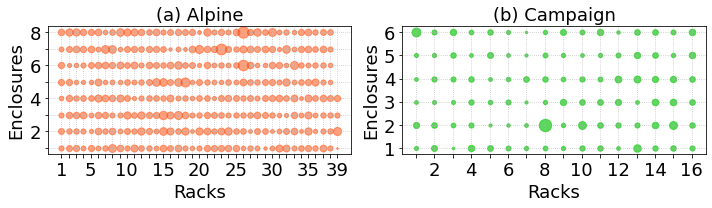

*********** Alpine ***********
0-25: 98.70%
25-50: 1.30%
50-75: 0.00%
75-100: 0.00%
100+: 0.00%
Counts per range: {'0-25': 304, '25-50': 4, '50-75': 0, '75-100': 0, '100+': 0}
Rack-Enclosure Combinations with 25<Failures>50: 
Enclosure 5, Rack 18: 28 Failures
Enclosure 6, Rack 26: 37 Failures
Enclosure 7, Rack 23: 39 Failures
Enclosure 8, Rack 26: 43 Failures
*********** Campaign ***********
0-25: 94.79%
25-50: 4.17%
50-75: 0.00%
75-100: 1.04%
100+: 0.00%
Counts per range: {'0-25': 91, '25-50': 4, '50-75': 0, '75-100': 1, '100+': 0}
Rack-Enclosure Combinations with 25<Failures>50: 
Enclosure 1, Rack 13: 28 Failures
Enclosure 2, Rack 10: 31 Failures
Enclosure 2, Rack 15: 31 Failures
Enclosure 6, Rack 1: 39 Failures
*********** Alpine ***********
2019
----
first half:  0.4445893089960887
second half:  0.45436766623207303
top panel:  0.10104302477183832
2020
----
first half:  0.27510917030567683
second half:  0.6229985443959243
top panel:  0.10189228529839883
2021
----
first half:  0.3480

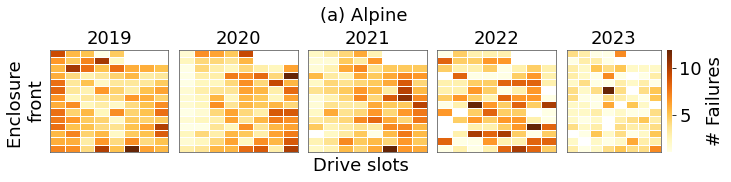

*********** Campaign ***********
2021
----
first half:  0.4830508474576271
second half:  0.5169491525423728
2022
----
first half:  0.3263157894736842
second half:  0.6736842105263158
2023
----
first half:  0.5106732348111659
second half:  0.48932676518883417


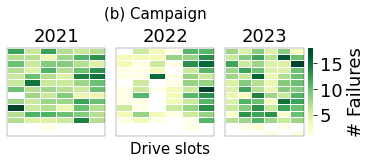

In [11]:
if __name__ == "__main__":
    main()